In [ ]:
import torch
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from matplotlib import pyplot as plt
import random
import numpy as np
#TODO: failed


In [54]:
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(3),
    ToTensor()
])
raw_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transformer
)

raw_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transformer
)
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

torch.manual_seed(123)
np.random.seed(123)

In [107]:
def linear_beta_schedule(timesteps):
    beta_start = 1e-3
    beta_end = 2e-1
    return torch.linspace(beta_start,beta_end, timesteps)


def forward_diffusion(img, t, noise_schedule):
    # Gather beta values for each timestep t (shape: [batch])
    beta_t = noise_schedule[t].reshape(-1, 1, 1, 1)  # reshape for broadcasting

    noise = torch.randn_like(img)
    return torch.sqrt(1 - beta_t) * img + torch.sqrt(beta_t) * noise


def forward (img: torch.Tensor,noise_schedule):
    for step in range(len(noise_schedule)):
        img = forward_diffusion(img,step,noise_schedule)
    return img

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self,in_channels, out_channels, features = [64,128,256,512]):
        super().__init__()
        self.encoder = torch.nn.ModuleList()
        for feature in features:
            self.encoder.append(self.conv_block(in_channels,feature))
            in_channels = feature

        self.bottleneck = self.conv_block(features[-1], features[-1] * 2)

        self.decoder = torch.nn.ModuleList()
        for feature in reversed(features):
            self.decoder.append(torch.nn.ConvTranspose2d(feature *2 , feature, kernel_size=2, stride=2))
            self.decoder.append(self.conv_block(feature*2, feature))
        self.final_layer = torch.nn.Conv2d(features[0], out_channels, kernel_size=1)


    def conv_block(self,in_channels, out_channels):
        return torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3, padding=1),
            torch.nn.ReLU()
        )
    
    def forward(self, x):
        skip_connections = []

        for layer in self.encoder:
            x = layer(x)
            skip_connections.append(x)
            x = torch.nn.MaxPool2d(kernel_size=2, stride=2)(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)  # ConvTranspose2d
            skip_connection = skip_connections[idx // 2]

            # Resize if needed
            if x.shape[2:] != skip_connection.shape[2:]:
                x = torch.nn.functional.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx + 1](x)  # conv_block

        return self.final_layer(x)
    


In [98]:
class VAEEncoder(torch.nn.Module):
    def __init__(self,in_channels, latent_dim):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 64, kernel_size=4,stride= 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,latent_dim,kernel_size=4,stride=2, padding=1)
        )

    def forward(self,x):
        return self.encoder(x)
    
class VAEDecoder(torch.nn.Module):
    def __init__(self, latent_dim,out_channels):
        super().__init__()
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(latent_dim, 128, kernel_size=4,stride= 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64,latent_dim,kernel_size=4,stride=2, padding=1)
        )

    def forward(self,x):
        return self.decoder(x)


class VAE(torch.nn.Module):
    def __init__(self,in_channels,latent_dim, out_channels):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dim)
        self.decoder = VAEDecoder(latent_dim, out_channels)
    def forward(self,x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed
    


In [101]:
loss_fn = torch.nn.MSELoss()
model = Unet(in_channels=3, out_channels=3)
optimizer = torch.optim.Adam(model.parameters())
dataloader = torch.utils.data.DataLoader(raw_training_data, batch_size=64, shuffle=True)

epochs = 100
timesteps = 10
beta_schedule = linear_beta_schedule(timesteps)  # Should return a tensor of shape [timesteps]


In [108]:
for epoch in range(500):
    
    step =0

    for img, _ in [raw_training_data[0]]:
        
        img = img.to(torch.float32)  # Ensure float for model and noise
        t = torch.randint(0, timesteps, (img.shape[0],), device=img.device)  # (batch,) shape

        noise = torch.randn_like(img)
        noisy_img = forward_diffusion(img, t, beta_schedule)  # Assumes function adds noise based on t

        predicted_noise = model(noisy_img)

        loss = loss_fn(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.9952
Epoch 2, Loss: 0.9724
Epoch 3, Loss: 1.0302
Epoch 4, Loss: 0.9346
Epoch 5, Loss: 0.9871
Epoch 6, Loss: 1.0113
Epoch 7, Loss: 1.0047
Epoch 8, Loss: 1.0241
Epoch 9, Loss: 0.9559
Epoch 10, Loss: 1.0315
Epoch 11, Loss: 0.9709
Epoch 12, Loss: 1.0269
Epoch 13, Loss: 1.0217
Epoch 14, Loss: 1.0118
Epoch 15, Loss: 0.9822
Epoch 16, Loss: 0.9764
Epoch 17, Loss: 0.9408
Epoch 18, Loss: 0.9800
Epoch 19, Loss: 1.0262
Epoch 20, Loss: 1.0028
Epoch 21, Loss: 1.0289
Epoch 22, Loss: 0.9501
Epoch 23, Loss: 1.0096
Epoch 24, Loss: 0.9682
Epoch 25, Loss: 1.0119
Epoch 26, Loss: 1.0207
Epoch 27, Loss: 0.9735
Epoch 28, Loss: 1.0412
Epoch 29, Loss: 0.9648
Epoch 30, Loss: 0.9831
Epoch 31, Loss: 1.0238
Epoch 32, Loss: 0.9903
Epoch 33, Loss: 0.9964
Epoch 34, Loss: 1.0195
Epoch 35, Loss: 0.9877
Epoch 36, Loss: 1.0057
Epoch 37, Loss: 0.9701
Epoch 38, Loss: 1.0341
Epoch 39, Loss: 1.0307
Epoch 40, Loss: 1.0360
Epoch 41, Loss: 1.0012
Epoch 42, Loss: 0.9886
Epoch 43, Loss: 0.9928
Epoch 44, Loss: 1.00

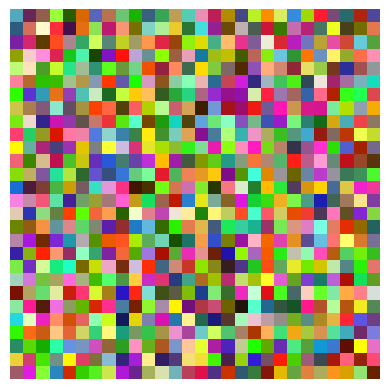

In [109]:
noise_image = torch.rand((1, 3, 28, 28))
denoised_img = noise_image.clone()  # Start from noisy image

for i in range(10):
    denoised_img = denoised_img - model(denoised_img)  # Subtract predicted noise

# Convert for display: [1, 3, 28, 28] → [28, 28, 3]
img = denoised_img.squeeze(0).permute(1, 2, 0).detach().clamp(0, 1)  # Clamp to [0,1] for visualization

plt.imshow(img)
plt.axis("off")
plt.show()